# Once and for All! MRI-Based Deep Learning for MGMT Promoter Methylation
This notebook contains the results of the confidence metrics on the validation and test sets.

<u> Table of contents </u>

1. [Introduction](#1)
2. [FLAIR-T1wCE - Whole MRIs - Early Fusion](#2)
3. [FLAIR - Whole MRI](#3)
4. [T1wCE - Whole MRI](#4)
5. [FLAIR - Tumor Centered](#5)
6. [T1wCE - Tumor Centered](#6)
7. [FLAIR-T1wCE - Tumor centered - Early Fusion](#7)
8. [FLAIR-T1wCE - Whole MRIs - Intermediate Fusion](#8)

#### <a id="1"></a> 1. Introduction
Useful imports and python functions.

In [1]:
# Standard libraries
import os
from typing import Dict, Tuple, List

# Third-party libraries
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve, accuracy_score
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import tqdm
from captum.attr import IntegratedGradients

# Local dependencies
from mgmt_conf.datasets import * 
from mgmt_conf.models import ResNet10Wrapper, MultimodalModel
from mgmt_conf.utils import prepare_dataframes

In [2]:
# Editable part
n_gpus = 4
weights_path = "../trained"
methods = ("Baseline", "Confidence Branch", "ODIN", "ABC Metric")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = "../rsna-miccai-brain-tumor-radiogenomic-classification/"
path_test = "/media/hddext/medical/MGMT_molecular_data/methylated_vs_non_methylated"

In [3]:
# Utilitary python functions
def get_baseline(model: nn.Module, dataloader: DataLoader, intermediate: bool = False) -> Tuple[List[float], List[float], List[int]]:
    scores = []
    predictions= []
    true_labels = []
    for inputs, targets in dataloader:
        with torch.no_grad():
            if not intermediate:
                inputs = inputs.to(device)
            outputs = model(inputs)
            top_proba, preds = torch.max(outputs.softmax(1), 1)
            scores.extend(top_proba.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
            predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())
    
    return scores, predictions, true_labels

def get_confidence_branch(model: nn.Module, dataloader: DataLoader, intermediate: bool = False) -> Tuple[List[float], List[float], List[int]]:
    scores = []
    predictions = []
    true_labels = []
    for inputs, targets in dataloader:
        with torch.no_grad():
            if not intermediate:
                inputs = inputs.to(device)
            outputs, conf = model(inputs)
            top_proba, preds = torch.max(outputs.softmax(1), 1)
            

            scores.extend(torch.sigmoid(conf).squeeze(0).cpu().numpy())
            #if conf.size(0) != 1:
            #    scores.extend(torch.sigmoid(conf).squeeze().cpu().numpy())
            #else:
            #    scores.extend(torch.sigmoid(conf).cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
            predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                        .detach()
                        .cpu()
                        .numpy())
            
    return scores, predictions, true_labels

def _initialize_item_adv(item: Dict[str, torch.tensor]) -> Dict[str, torch.tensor]:
    item_adv = {}
    for key in item.keys():
        item_adv[key] = item[key].detach().clone()#.unsqueeze(dim=0)
        item_adv[key].requires_grad = True
    return item_adv

def _step(item: Dict[str, torch.tensor]) -> Dict[str, torch.tensor]:
    for key in item.keys():
        item[key] = item[key] - 1e-3 * torch.sign(item[key].grad)

    return item
        
def get_odin(model: nn.Module, dataloader: DataLoader, intermediate: bool = False) -> Tuple[List[float], List[float], List[int]]:
    scores = []
    predictions = []
    true_labels = []
    for inputs, targets in dataloader:
        model.zero_grad()
        if intermediate:
            inputs_bis = _initialize_item_adv(inputs)
        else:
            inputs_bis = inputs.detach().clone()
            inputs_bis.requires_grad = True
        pred = model(inputs_bis)
        _, pred_idx = torch.max(pred.data, 1)
        pred = pred / 100
        loss = F.cross_entropy(pred, pred_idx)
        loss.backward()
        if intermediate:
            inputs_bis = _step(inputs_bis)
        else:
            inputs_bis = inputs_bis - 1e-3 * torch.sign(inputs_bis.grad)

        pred = model(inputs_bis)

        pred = pred / 100
        pred = F.softmax(pred, dim=1)
        top_proba, preds = torch.max(pred.data, 1)
        scores.extend(top_proba.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())
        
    return scores, predictions, true_labels

def get_abc_metric(model: nn.Module, dataloader: DataLoader) -> Tuple[List[float], List[float], List[int]]:
    p_size = (6, 6, 2)
    scores = []
    predictions = []
    true_labels = []
    for inputs, targets in tqdm.tqdm(dataloader, desc='Iterating...'):
        inputs = inputs.to(device)
        #inputs = inputs.unsqueeze(0)
        bs, channels, height, width, depth = inputs.shape
        baseline = torch.full(inputs.size(), inputs.min()).to(device)
        features = (inputs - inputs.min()) / (inputs.max() - inputs.min())
        with torch.no_grad():
            outputs = model(inputs)
            top_proba, preds = torch.max(outputs.softmax(1), 1)

        integratedGrads = IntegratedGradients(model.forward, False)
        attrs = integratedGrads.attribute(inputs, baseline, preds, n_steps=40)
        ratio = torch.abs(attrs / (features + 1e-5)).sum(dim=1).reshape(1, 1, height, width, depth)
        ratio_patches = ratio.unfold(2, p_size[0], p_size[0]).unfold(3, p_size[1], p_size[1]).unfold(4, p_size[2], p_size[2])

        ratio_sum = ratio_patches.sum((5, 6, 7)).reshape(1, 1, height // p_size[0], width // p_size[1], depth // p_size[2], 1, 1, 1).expand_as(ratio_patches)
        probs_patches = ratio_patches / ratio_sum
        unfold_shape = probs_patches.size()
        probs = probs_patches.view(unfold_shape)
        probs = probs.permute(0, 1, 2, 5, 3, 6, 4, 7).contiguous()
        probs = probs.view(ratio.size())
        conformance = []
        for _ in range(50):
            inputs_bis = torch.where(torch.bernoulli(probs.clamp_min(1e-1)) == 1, baseline, inputs)
            #inputs_bis = inputs * ~(torch.bernoulli(probs.clamp_min(1e-1)).bool())
            pred = model(inputs_bis).argmax().item()
            conformance.append(pred)

        scores.append(np.mean(np.array(conformance) == preds.item()))
        true_labels.append(targets.item())
        final_pred = top_proba.item() if preds.item() == 1 else 1 - top_proba.item()
        predictions.append(final_pred)
        
    return scores, predictions, true_labels
        
def plot_a_report(scores: List[float], predictions: List[float], true_labels: List[int]) -> None:

    colors = ["yellow", "green", "purple", "darkorange", "cyan"]
    percentiles = (0, 25, 50, 70)
    thresholds = np.percentile(scores, percentiles)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    for i, threshold in enumerate(thresholds):
        idx = np.array(scores) >= threshold
        fpr, tpr, _ = roc_curve(np.array(true_labels)[idx], np.array(predictions)[idx])
        acc = accuracy_score(np.array(true_labels)[idx], np.where(np.array(predictions) > 0.5, 1, 0)[idx])

        precision, recall, _ = precision_recall_curve(np.array(true_labels)[idx], np.array(predictions)[idx])
        average_precision = average_precision_score(np.array(true_labels)[idx], np.array(predictions)[idx])
        roc_auc = auc(fpr, tpr)
        ax[0].plot(
            fpr,
            tpr,
            color=colors[i],
            lw=2,
            label=f"ROC curve: {roc_auc:.2f} / Accuracy: {acc:.2f} /% considered: {np.sum(idx)/len(scores)*100:.0f}",
        )

        ax[1].plot(recall, precision, color=colors[i], lw=2, label=f"PR (AP = {average_precision:.2f}) /% considered: {np.sum(idx)/len(scores)*100:.0f}")
        print(f"Percentile {percentiles[i]}: Acc = {acc:.2f}, AP = {average_precision:.2f}, AUC = {roc_auc:.2f}")
    ax[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("Receiver operating characteristic")
    ax[0].legend(loc="lower right")

    ax[1].plot([0, 1], [0.5, 0.5], color="navy", lw=2, linestyle="--")
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title("Precision Recall")
    ax[1].legend(loc="lower left")
    
    
def create_df(folder: str, only_positive: bool = False) -> pd.DataFrame:

    df_path_methylated = os.path.join(folder, "listing_all_but_non_methylated.xlsx")
    df_m = pd.read_excel(df_path_methylated, sheet_name=2, skiprows=[1], header=1)
    df_m = df_m[["NNNPP", "% Méthylé"]]
    df_m = df_m.drop(0)
    df_m = df_m.drop(28)

    if only_positive:
        return df_m
    
    
    df_path_unmethylated = os.path.join(folder, "listing_non_methylated.xlsx")
    df_u = pd.read_excel(df_path_unmethylated, skiprows=0, header=2)
    df_u = df_u[["NNNPP"]]
    df_u = df_u.drop(0)
    df_u["% Méthylé"] = np.zeros(len(df_u))
    df = pd.concat([df_m, df_u], ignore_index=True)
    return df

def methyl_percentage_to_score(x: torch.tensor) -> torch.tensor:
    return torch.where(x > 10., x - 10., ((10-x))*torch.exp((10-x)/5.5))
    
_, dataframe_val = prepare_dataframes(os.path.join(path, "train_labels.csv"), 42)

##### Test settings...

In [4]:
df = create_df(path_test, only_positive=False)

In [5]:
weights = os.path.join(weights_path, "nifti")

#### <a id="2"></a> 2. FLAIR-T1wCE - Whole MRIs - Early Fusion

In [6]:
dataset = MultimodalMGMTNiftiDataset(os.path.join(path, 'archive'), dataframe_val, ("FLAIR", "T1wCE"), 'early', image_size=(180, 180), depth=64, tumor_centered=False, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [7]:
model = ResNet10Wrapper(n_input_channels=2, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "early_FLAIR-T1wCE_tumor_centered_False.pth")))
model = model.to(device)
model.eval()

model_branch = ResNet10Wrapper(2, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "early_FLAIR-T1wCE_tumor_centered_False.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [8]:
baseline = get_baseline(model, dataloader)
odin = get_odin(model, dataloader)
abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(
Iterating...:   0%|          | 0/173 [00:12<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.24 GiB (GPU 0; 10.76 GiB total capacity; 4.54 GiB already allocated; 575.69 MiB free; 4.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Percentile 0: Acc = 0.64, AP = 0.62, AUC = 0.62
Percentile 25: Acc = 0.62, AP = 0.59, AUC = 0.59
Percentile 50: Acc = 0.56, AP = 0.59, AUC = 0.58
Percentile 70: Acc = 0.65, AP = 0.61, AUC = 0.58
Percentile 0: Acc = 0.64, AP = 0.62, AUC = 0.61
Percentile 25: Acc = 0.62, AP = 0.59, AUC = 0.59
Percentile 50: Acc = 0.55, AP = 0.60, AUC = 0.58
Percentile 70: Acc = 0.65, AP = 0.64, AUC = 0.60
Percentile 0: Acc = 0.64, AP = 0.65, AUC = 0.63
Percentile 25: Acc = 0.67, AP = 0.67, AUC = 0.66
Percentile 50: Acc = 0.62, AP = 0.65, AUC = 0.62
Percentile 70: Acc = 0.65, AP = 0.70, AUC = 0.70
Percentile 0: Acc = 0.64, AP = 0.62, AUC = 0.62
Percentile 25: Acc = 0.64, AP = 0.62, AUC = 0.62
Percentile 50: Acc = 0.60, AP = 0.44, AUC = 0.49
Percentile 70: Acc = 0.60, AP = 0.44, AUC = 0.49


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1091710/1195563051.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1091710/1195563051.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

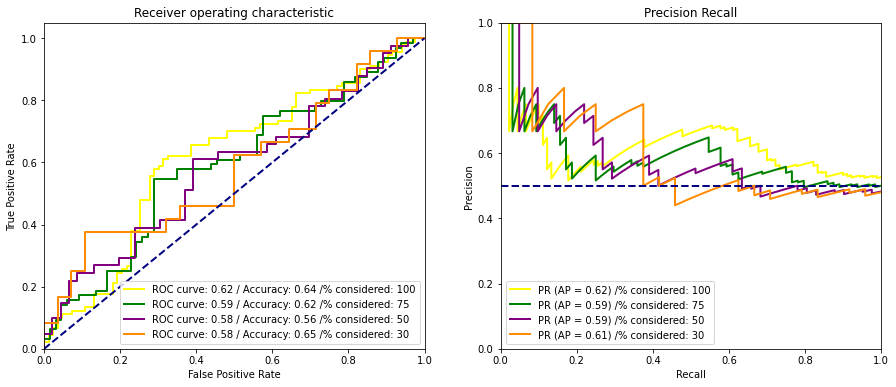

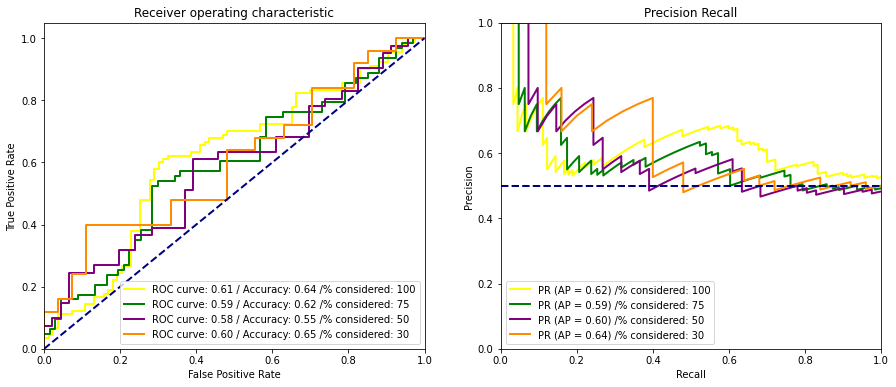

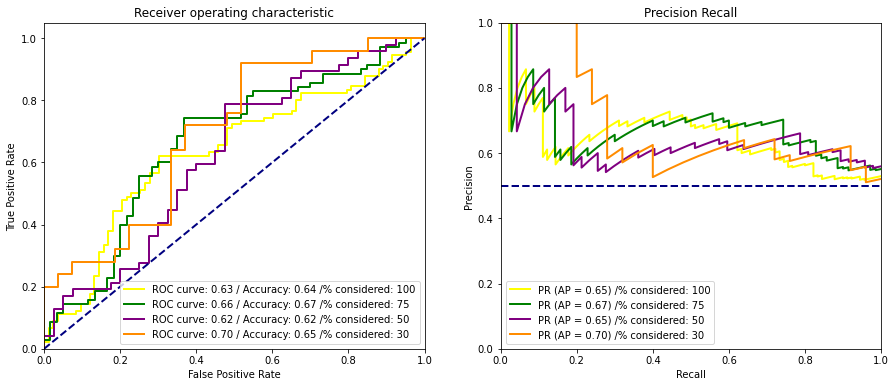

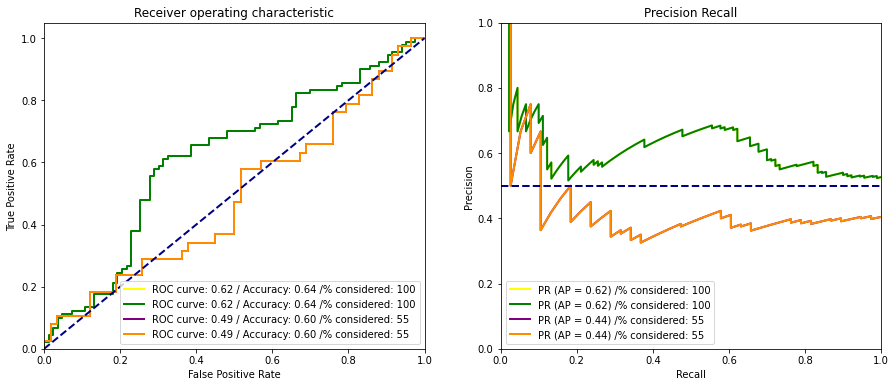

In [45]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)
plot_a_report(*abc)

Percentile 0: Acc = 0.64, AP = 0.62, AUC = 0.62
Percentile 25: Acc = 0.62, AP = 0.59, AUC = 0.59
Percentile 50: Acc = 0.56, AP = 0.59, AUC = 0.58
Percentile 70: Acc = 0.65, AP = 0.61, AUC = 0.58


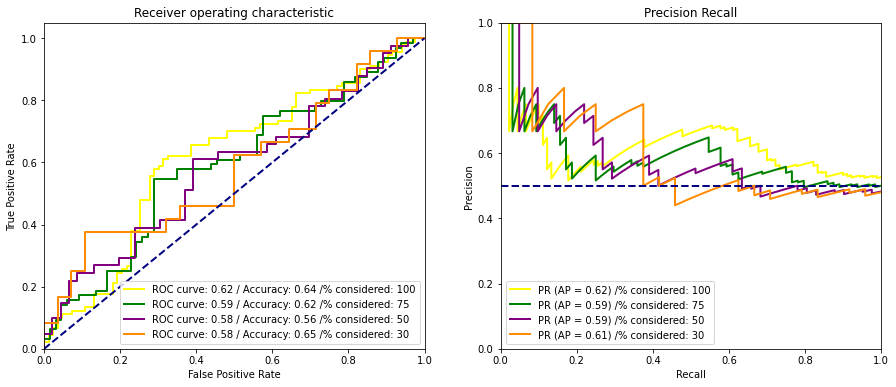

In [47]:
plot_a_report(*baseline)
plt.savefig("../image_final/baseline_FLAIR_T1wCE_early_nifti_tumor_centered_False.pdf")

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1091710/1195563051.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1091710/1195563051.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

Percentile 0: Acc = 0.64, AP = 0.65, AUC = 0.63
Percentile 25: Acc = 0.67, AP = 0.67, AUC = 0.66
Percentile 50: Acc = 0.62, AP = 0.65, AUC = 0.62
Percentile 70: Acc = 0.65, AP = 0.70, AUC = 0.70


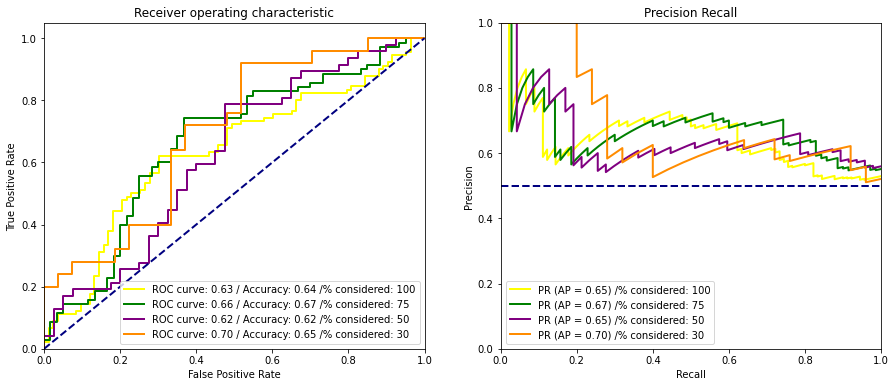

In [48]:
plot_a_report(*conf_branch)
plt.savefig("../image_final/conf_branch_FLAIR_T1wCE_early_nifti_tumor_centered_False.pdf")

In [36]:
test_dataset = MultimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modalities=("FLAIR", "T1wCE"), image_size=(180,180), depth=64)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())


Percentile 0: Acc = 0.48, AP = 0.62, AUC = 0.55
Percentile 25: Acc = 0.52, AP = 0.54, AUC = 0.55
Percentile 50: Acc = 0.61, AP = 0.39, AUC = 0.61
Percentile 70: Acc = 0.64, AP = 0.49, AUC = 0.75


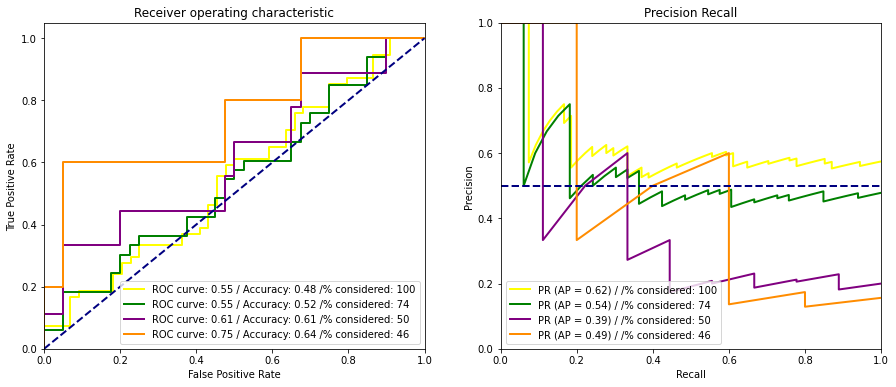

In [43]:
plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/nifti_early_not_tumor_centered_FLAIR_T1wCE.pdf")

#### FLAIR - Whole MRI - nifti

In [6]:
dataset = UnimodalMGMTNiftiDataset(os.path.join(path, 'archive'), dataframe_val, "FLAIR", image_size=(180, 180), depth=64, tumor_centered=False, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [7]:
model = ResNet10Wrapper(n_input_channels=1, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "early_FLAIR_tumor_centered_False.pth")))
model = model.to(device)
model.eval()

model_branch = ResNet10Wrapper(1, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "early_FLAIR_tumor_centered_False.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [8]:
baseline = get_baseline(model, dataloader)
odin = get_odin(model, dataloader)
abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(
Iterating...:   0%|          | 0/173 [00:09<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 1.24 GiB (GPU 0; 10.76 GiB total capacity; 4.21 GiB already allocated; 933.69 MiB free; 4.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Percentile 0: Acc = 0.62, AP = 0.65, AUC = 0.65
Percentile 25: Acc = 0.65, AP = 0.66, AUC = 0.66
Percentile 50: Acc = 0.66, AP = 0.61, AUC = 0.63
Percentile 70: Acc = 0.63, AP = 0.62, AUC = 0.65
Percentile 0: Acc = 0.62, AP = 0.65, AUC = 0.65
Percentile 25: Acc = 0.64, AP = 0.66, AUC = 0.66
Percentile 50: Acc = 0.66, AP = 0.61, AUC = 0.63
Percentile 70: Acc = 0.63, AP = 0.64, AUC = 0.66
Percentile 0: Acc = 0.61, AP = 0.65, AUC = 0.63
Percentile 25: Acc = 0.64, AP = 0.66, AUC = 0.66
Percentile 50: Acc = 0.66, AP = 0.60, AUC = 0.64
Percentile 70: Acc = 0.69, AP = 0.66, AUC = 0.66
Percentile 0: Acc = 0.62, AP = 0.65, AUC = 0.65
Percentile 25: Acc = 0.62, AP = 0.65, AUC = 0.65
Percentile 50: Acc = 0.60, AP = 0.43, AUC = 0.55
Percentile 70: Acc = 0.60, AP = 0.43, AUC = 0.55


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1091710/1195563051.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1091710/1195563051.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

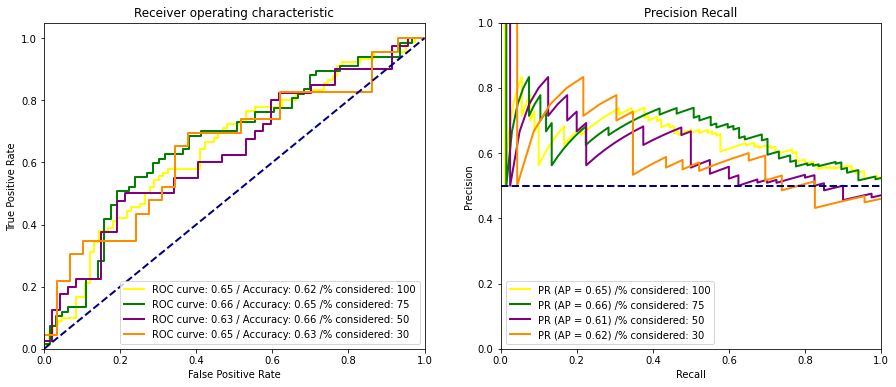

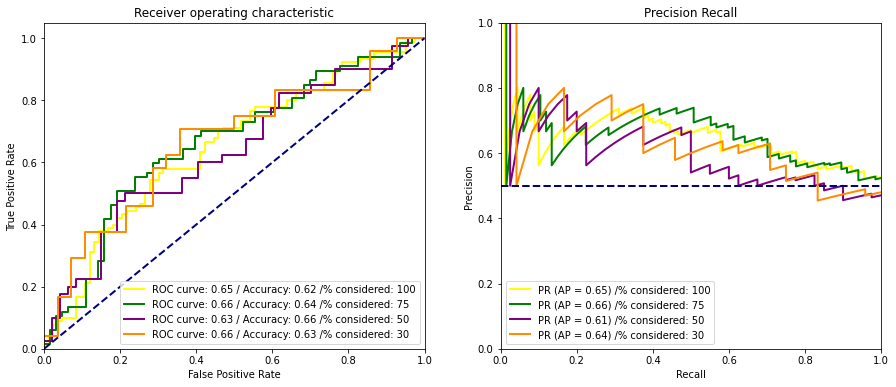

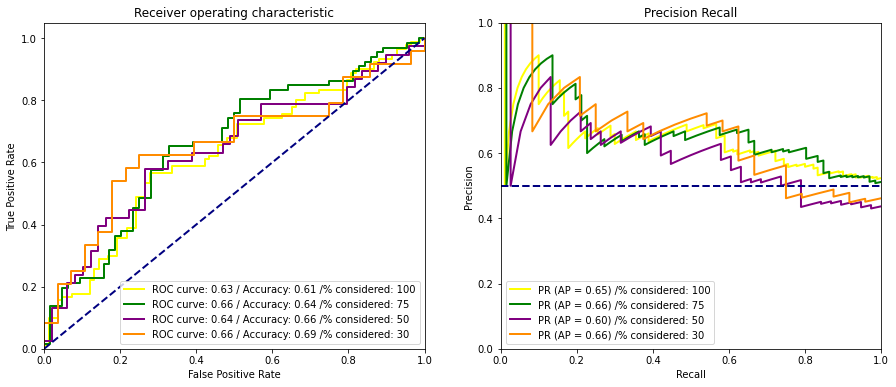

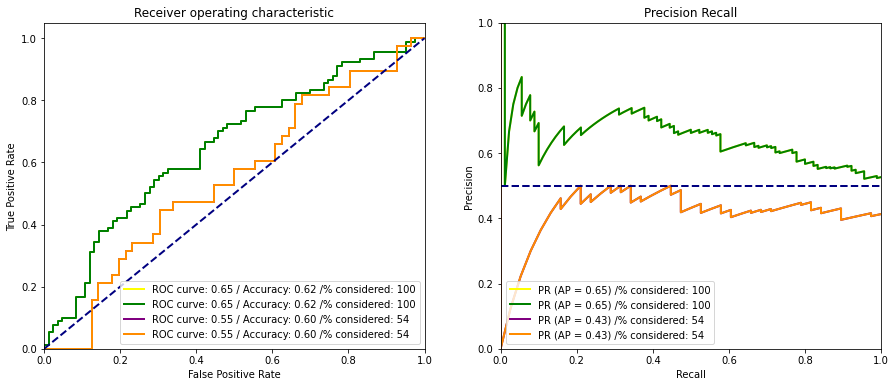

In [53]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)
plot_a_report(*abc)

Percentile 0: Acc = 0.45, AP = 0.59, AUC = 0.54
Percentile 25: Acc = 0.52, AP = 0.51, AUC = 0.53
Percentile 50: Acc = 0.69, AP = 0.34, AUC = 0.59
Percentile 70: Acc = 0.73, AP = 0.30, AUC = 0.46


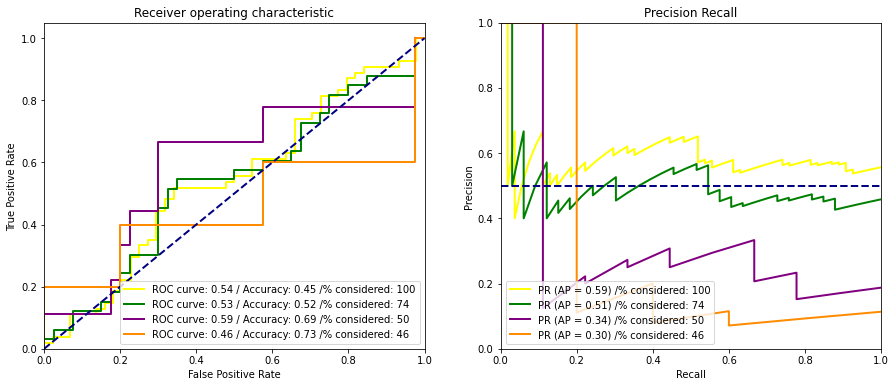

In [9]:
test_dataset = UnimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modality="FLAIR", image_size=(180,180), depth=64)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())

plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/nifti_early_not_tumor_centered_FLAIR.pdf")

#### T1wCE - Whole MRI - nifti

In [10]:
dataset = UnimodalMGMTNiftiDataset(os.path.join(path, 'archive'), dataframe_val, "T1wCE", image_size=(180, 180), depth=64, tumor_centered=False, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [11]:
model = ResNet10Wrapper(n_input_channels=1, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "early_T1wCE_tumor_centered_False.pth")))
model = model.to(device)
model.eval()

model_branch = ResNet10Wrapper(1, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "early_T1wCE_tumor_centered_False.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [12]:
baseline = get_baseline(model, dataloader)
odin = get_odin(model, dataloader)
abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(
Iterating...: 100%|██████████| 173/173 [03:46<00:00,  1.31s/it]


Percentile 0: Acc = 0.58, AP = 0.64, AUC = 0.60
Percentile 25: Acc = 0.59, AP = 0.65, AUC = 0.61
Percentile 50: Acc = 0.63, AP = 0.70, AUC = 0.62
Percentile 70: Acc = 0.65, AP = 0.73, AUC = 0.61
Percentile 0: Acc = 0.58, AP = 0.65, AUC = 0.61
Percentile 25: Acc = 0.60, AP = 0.65, AUC = 0.61
Percentile 50: Acc = 0.64, AP = 0.70, AUC = 0.63
Percentile 70: Acc = 0.65, AP = 0.74, AUC = 0.62
Percentile 0: Acc = 0.63, AP = 0.62, AUC = 0.61
Percentile 25: Acc = 0.69, AP = 0.68, AUC = 0.69
Percentile 50: Acc = 0.66, AP = 0.65, AUC = 0.66
Percentile 70: Acc = 0.60, AP = 0.54, AUC = 0.60
Percentile 0: Acc = 0.58, AP = 0.64, AUC = 0.60
Percentile 25: Acc = 0.58, AP = 0.64, AUC = 0.60
Percentile 50: Acc = 0.60, AP = 0.70, AUC = 0.56
Percentile 70: Acc = 0.60, AP = 0.70, AUC = 0.58


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1217091/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1217091/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

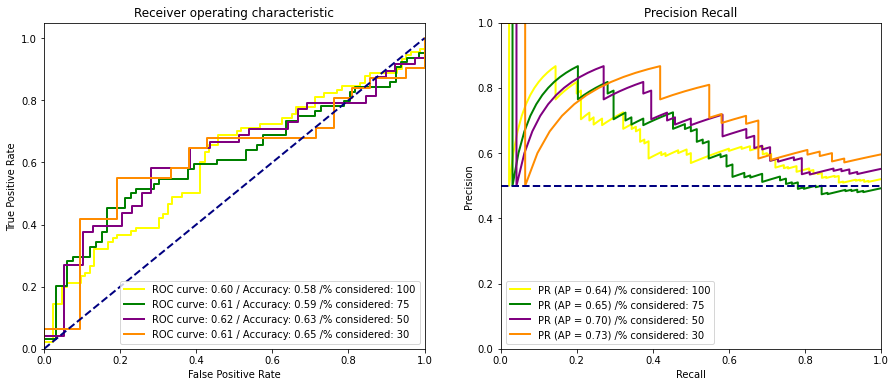

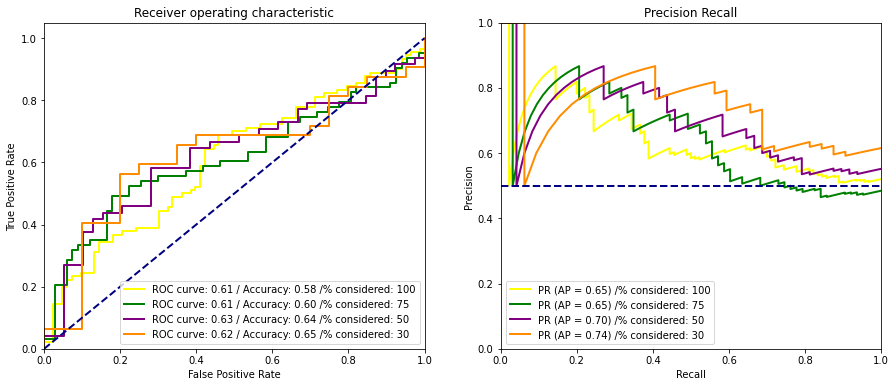

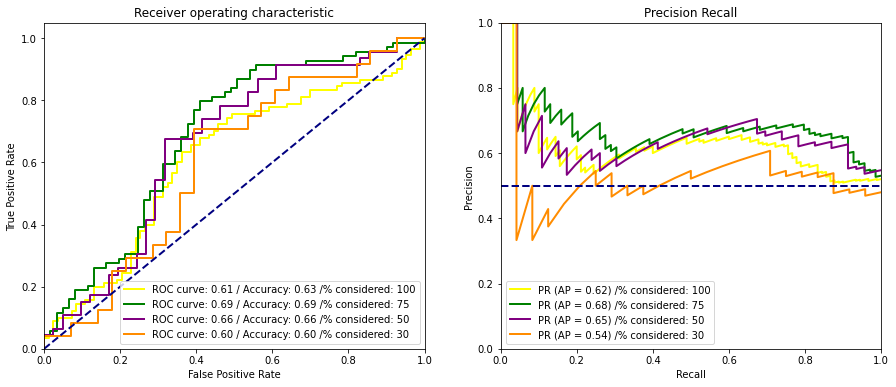

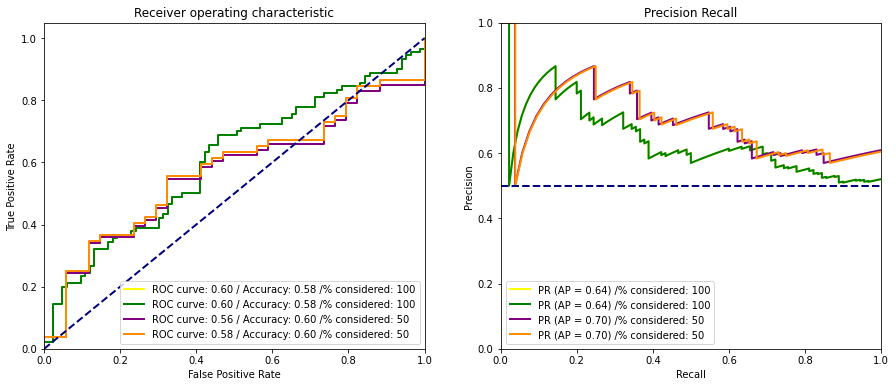

In [13]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)
plot_a_report(*abc)

Percentile 0: Acc = 0.50, AP = 0.55, AUC = 0.48
Percentile 25: Acc = 0.51, AP = 0.47, AUC = 0.46
Percentile 50: Acc = 0.55, AP = 0.26, AUC = 0.49
Percentile 70: Acc = 0.56, AP = 0.19, AUC = 0.48


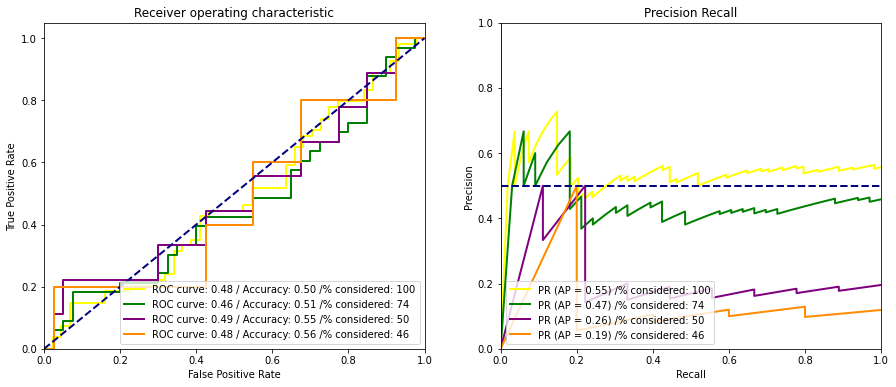

In [14]:
test_dataset = UnimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modality="T1wCE", image_size=(180,180), depth=64)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())

plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/nifti_early_not_tumor_centered_T1wCE.pdf")

#### FLAIR - Tumor Centered

In [5]:
dataset = UnimodalMGMTNiftiDataset(os.path.join(path, 'archive'), dataframe_val, "FLAIR", image_size=(96, 96), depth=32, tumor_centered=True, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [6]:
model = ResNet10Wrapper(n_input_channels=1, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "early_FLAIR_tumor_centered_True.pth")))
model = model.to(device)
model.eval()

model_branch = ResNet10Wrapper(1, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "early_FLAIR_tumor_centered_True.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [7]:
baseline = get_baseline(model, dataloader)
odin = get_odin(model, dataloader)
abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(
Iterating...: 100%|██████████| 173/173 [01:03<00:00,  2.72it/s]


Percentile 0: Acc = 0.56, AP = 0.56, AUC = 0.58
Percentile 25: Acc = 0.58, AP = 0.55, AUC = 0.59
Percentile 50: Acc = 0.59, AP = 0.54, AUC = 0.58
Percentile 70: Acc = 0.56, AP = 0.51, AUC = 0.60
Percentile 0: Acc = 0.56, AP = 0.56, AUC = 0.58
Percentile 25: Acc = 0.58, AP = 0.55, AUC = 0.58
Percentile 50: Acc = 0.59, AP = 0.54, AUC = 0.58
Percentile 70: Acc = 0.56, AP = 0.51, AUC = 0.59
Percentile 0: Acc = 0.51, AP = 0.55, AUC = 0.55
Percentile 25: Acc = 0.51, AP = 0.56, AUC = 0.57
Percentile 50: Acc = 0.49, AP = 0.51, AUC = 0.53
Percentile 70: Acc = 0.46, AP = 0.53, AUC = 0.55
Percentile 0: Acc = 0.56, AP = 0.56, AUC = 0.58
Percentile 25: Acc = 0.56, AP = 0.56, AUC = 0.58
Percentile 50: Acc = 0.52, AP = 0.48, AUC = 0.56
Percentile 70: Acc = 0.52, AP = 0.50, AUC = 0.57


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1336219/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1336219/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

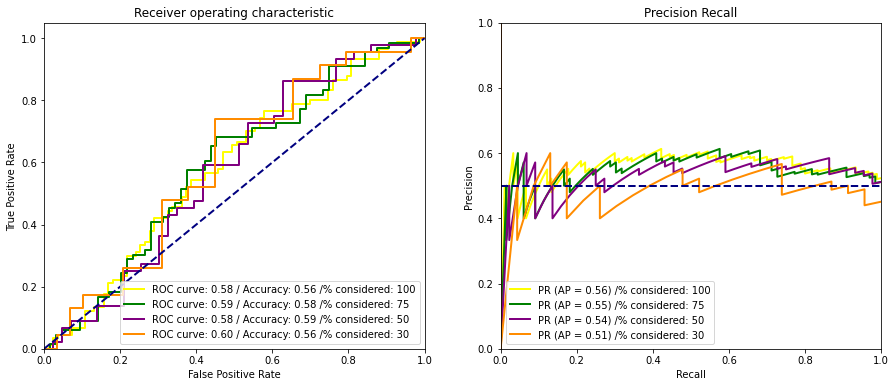

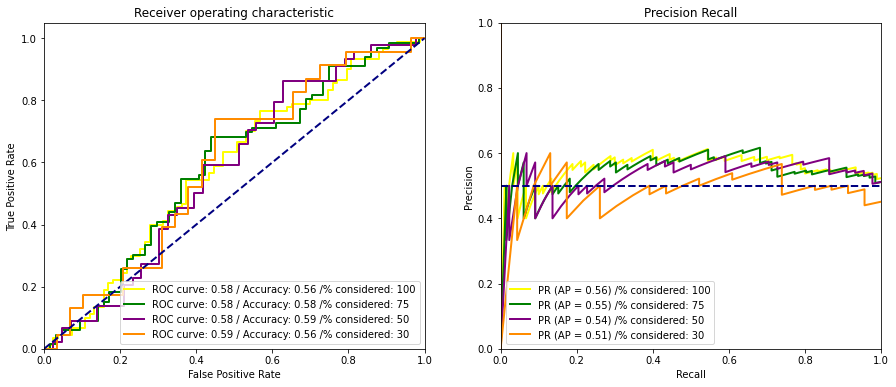

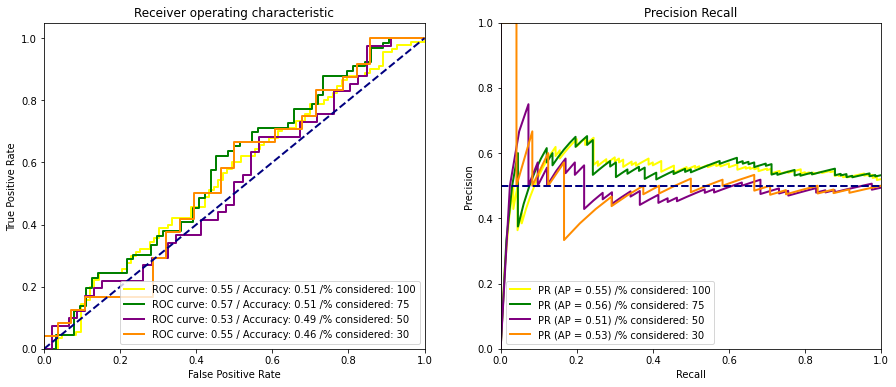

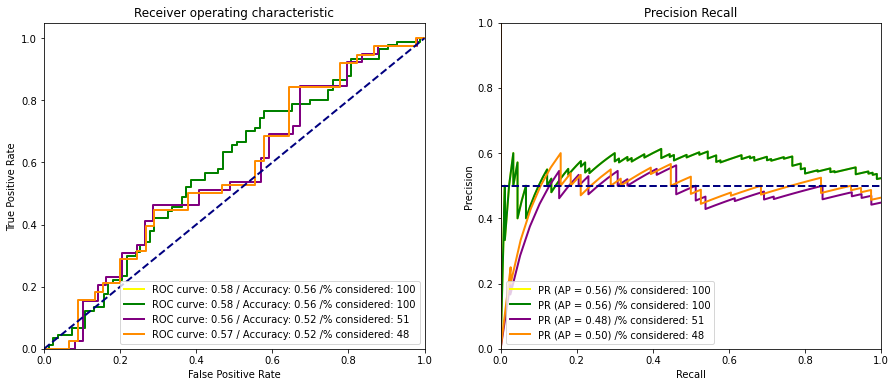

In [8]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)
plot_a_report(*abc)

Percentile 0: Acc = 0.49, AP = 0.53, AUC = 0.42
Percentile 25: Acc = 0.58, AP = 0.45, AUC = 0.44
Percentile 50: Acc = 0.71, AP = 0.21, AUC = 0.46
Percentile 70: Acc = 0.73, AP = 0.10, AUC = 0.35


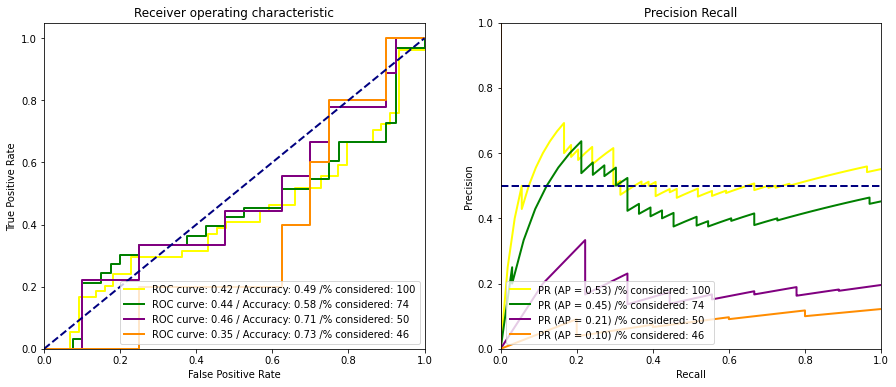

In [9]:
test_dataset = UnimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modality="FLAIR", image_size=(96,96), depth=32)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())

plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/nifti_early_tumor_centered_FLAIR.pdf")

#### T1wCE - Centered - Nifti

In [10]:
dataset = UnimodalMGMTNiftiDataset(os.path.join(path, 'archive'), dataframe_val, "T1wCE", image_size=(96, 96), depth=32, tumor_centered=True, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [17]:
model = ResNet10Wrapper(n_input_channels=1, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "early_T1wCE_tumor_centered_True.pth")))
model = model.to(device)
model.eval()

model_branch = ResNet10Wrapper(1, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "early_T1wCE_tumor_centered_True.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [13]:
baseline = get_baseline(model, dataloader)
odin = get_odin(model, dataloader)
abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(
Iterating...: 100%|██████████| 173/173 [01:03<00:00,  2.71it/s]


Percentile 0: Acc = 0.58, AP = 0.59, AUC = 0.57
Percentile 25: Acc = 0.57, AP = 0.60, AUC = 0.56
Percentile 50: Acc = 0.59, AP = 0.61, AUC = 0.57
Percentile 70: Acc = 0.58, AP = 0.66, AUC = 0.65
Percentile 0: Acc = 0.58, AP = 0.59, AUC = 0.57
Percentile 25: Acc = 0.57, AP = 0.60, AUC = 0.56
Percentile 50: Acc = 0.57, AP = 0.61, AUC = 0.57
Percentile 70: Acc = 0.58, AP = 0.65, AUC = 0.64
Percentile 0: Acc = 0.58, AP = 0.58, AUC = 0.58
Percentile 25: Acc = 0.57, AP = 0.60, AUC = 0.58
Percentile 50: Acc = 0.60, AP = 0.48, AUC = 0.50
Percentile 70: Acc = 0.65, AP = 0.58, AUC = 0.60
Percentile 0: Acc = 0.58, AP = 0.59, AUC = 0.57
Percentile 25: Acc = 0.56, AP = 0.60, AUC = 0.54
Percentile 50: Acc = 0.59, AP = 0.62, AUC = 0.53
Percentile 70: Acc = 0.60, AP = 0.67, AUC = 0.47


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1336219/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1336219/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

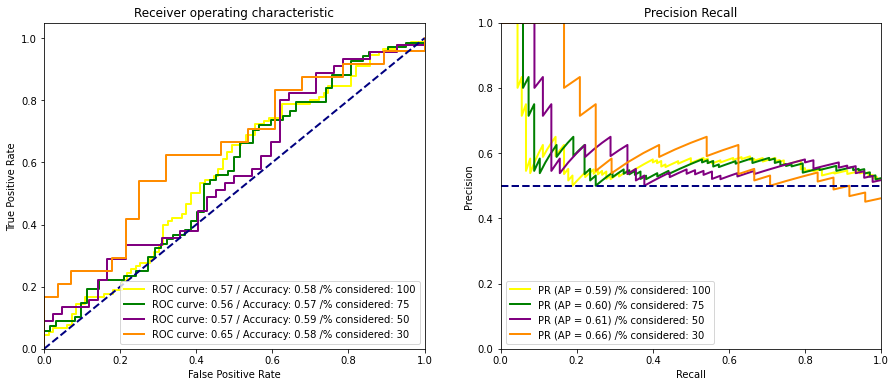

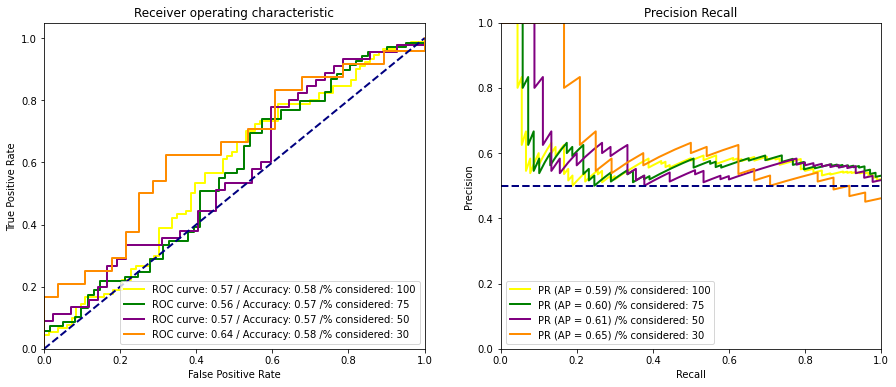

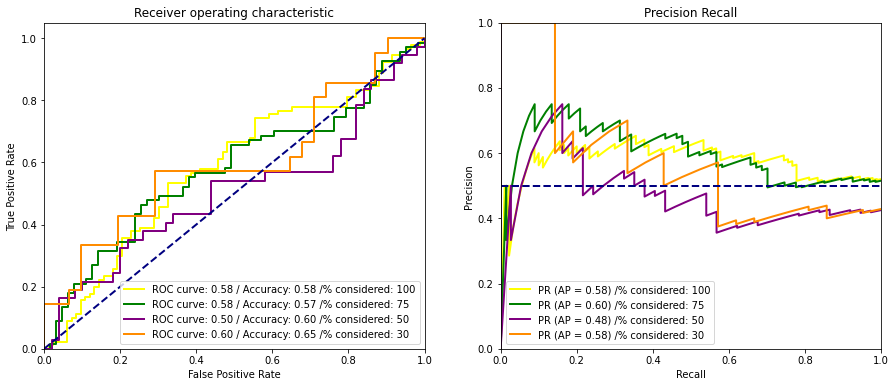

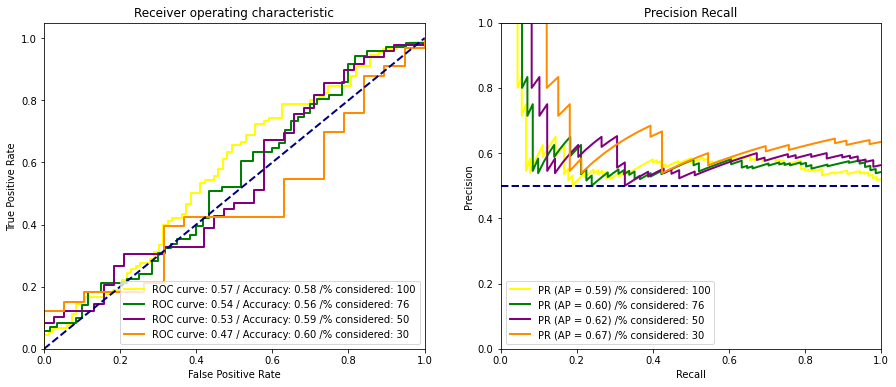

In [14]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)
plot_a_report(*abc)

Percentile 0: Acc = 0.42, AP = 0.53, AUC = 0.46
Percentile 25: Acc = 0.48, AP = 0.45, AUC = 0.50
Percentile 50: Acc = 0.63, AP = 0.22, AUC = 0.56
Percentile 70: Acc = 0.64, AP = 0.16, AUC = 0.57


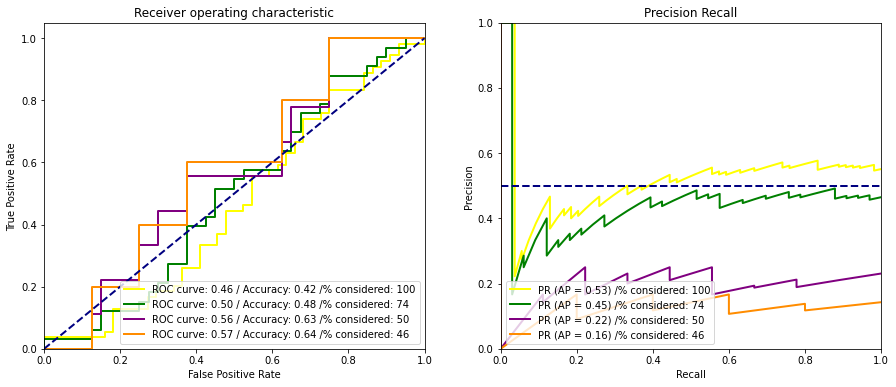

In [16]:
test_dataset = UnimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modality="T1wCE", image_size=(96,96), depth=32)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())

plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/nifti_early_tumor_centered_T1wCE.pdf")

#### Tumor CENTERED - FLAIR-T1wCE

In [19]:
dataset = MultimodalMGMTNiftiDataset(os.path.join(path, 'archive'), dataframe_val, ("FLAIR", "T1wCE"), fusion='early', image_size=(96, 96), depth=32, tumor_centered=True, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [20]:
model = ResNet10Wrapper(n_input_channels=2, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "early_FLAIR-T1wCE_tumor_centered_True.pth")))
model = model.to(device)
model.eval()

model_branch = ResNet10Wrapper(2, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "early_FLAIR-T1wCE_tumor_centered_True.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [21]:
baseline = get_baseline(model, dataloader)
odin = get_odin(model, dataloader)
abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(
Iterating...: 100%|██████████| 173/173 [01:12<00:00,  2.40it/s]


Percentile 0: Acc = 0.57, AP = 0.63, AUC = 0.59
Percentile 25: Acc = 0.61, AP = 0.64, AUC = 0.58
Percentile 50: Acc = 0.59, AP = 0.66, AUC = 0.57
Percentile 70: Acc = 0.56, AP = 0.71, AUC = 0.60
Percentile 0: Acc = 0.57, AP = 0.62, AUC = 0.59
Percentile 25: Acc = 0.60, AP = 0.64, AUC = 0.58
Percentile 50: Acc = 0.59, AP = 0.64, AUC = 0.56
Percentile 70: Acc = 0.54, AP = 0.68, AUC = 0.58
Percentile 0: Acc = 0.55, AP = 0.58, AUC = 0.56
Percentile 25: Acc = 0.58, AP = 0.60, AUC = 0.58
Percentile 50: Acc = 0.52, AP = 0.49, AUC = 0.51
Percentile 70: Acc = 0.46, AP = 0.42, AUC = 0.44
Percentile 0: Acc = 0.57, AP = 0.63, AUC = 0.59
Percentile 25: Acc = 0.56, AP = 0.61, AUC = 0.57
Percentile 50: Acc = 0.53, AP = 0.53, AUC = 0.49
Percentile 70: Acc = 0.55, AP = 0.54, AUC = 0.49


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1336219/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1336219/1032601020.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

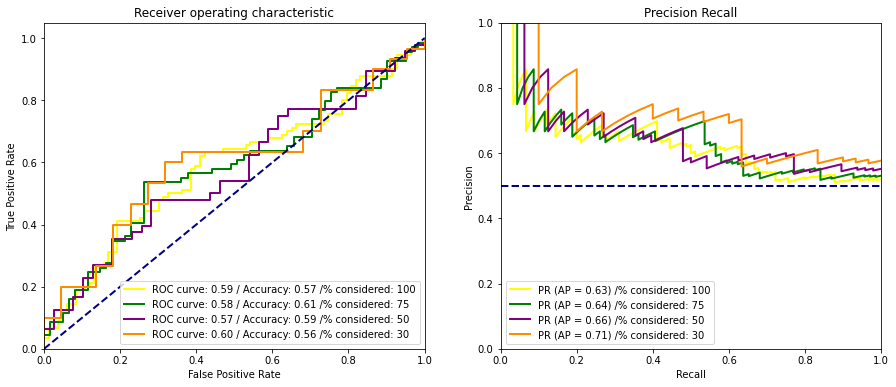

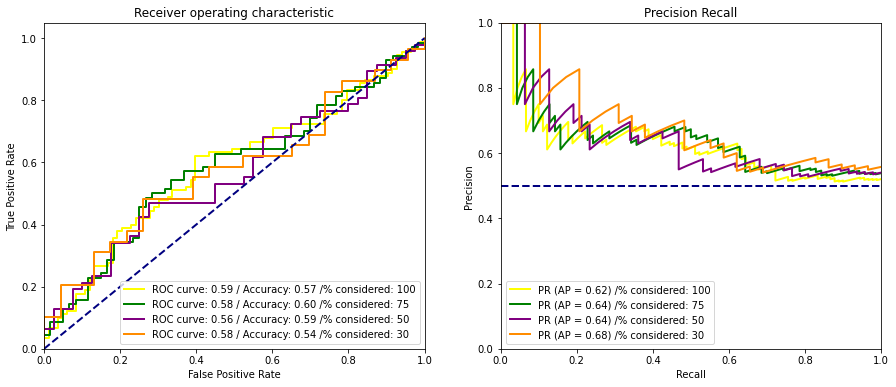

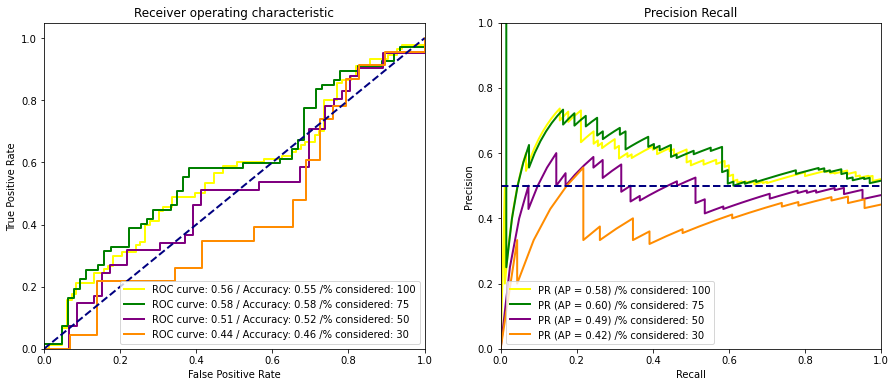

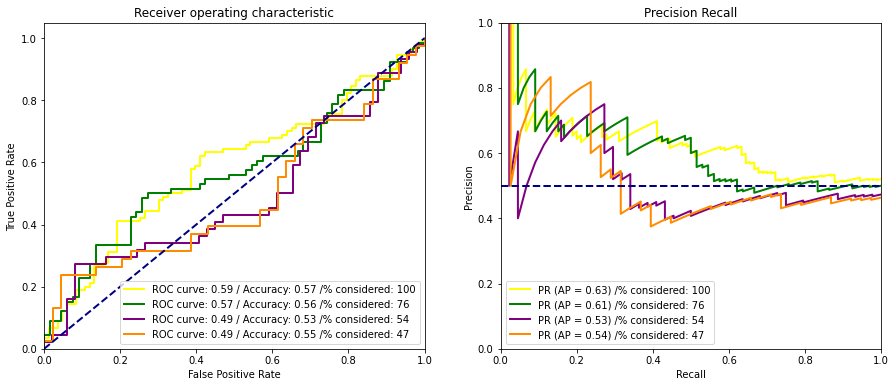

In [22]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)
plot_a_report(*abc)

Percentile 0: Acc = 0.47, AP = 0.56, AUC = 0.47
Percentile 25: Acc = 0.55, AP = 0.50, AUC = 0.43
Percentile 50: Acc = 0.69, AP = 0.32, AUC = 0.41
Percentile 70: Acc = 0.71, AP = 0.17, AUC = 0.24


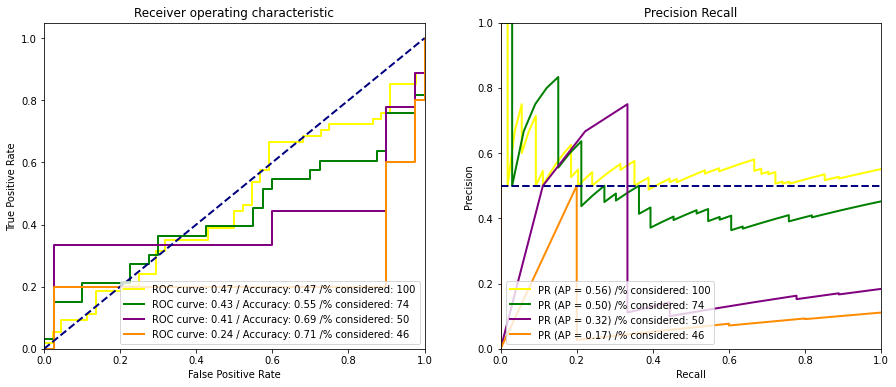

In [25]:
test_dataset = MultimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modalities=("FLAIR", "T1wCE"), fusion='early', image_size=(96,96), depth=32)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())

plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/nifti_early_tumor_centered_FLAIR-T1wCE.pdf")

#### FLAIR T1WCE - Intermediate - DICOM

In [5]:
weights = os.path.join(weights_path, "dicom")
dataset = MultimodalMGMTDicomDataset(path, dataframe_val, ("FLAIR", "T1wCE"), image_size=(180, 180), split="train", depth=64, augment=False)
dataloader = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=4)
dataloader_abc = DataLoader(dataset, num_workers=40, shuffle=False, batch_size=1)

In [6]:
base_model = ResNet10Wrapper(n_input_channels=1, n_classes=2, confidence_branch=False, embracenet=True)
model = MultimodalModel(base_model, ("FLAIR", "T1wCE"), device, confidence_branch=False)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
model.load_state_dict(torch.load(os.path.join(weights, "regular", "intermediate_FLAIR-T1wCE_tumor_centered_True.pth")))
model = model.to(device)
model.eval()

base_model_branch = ResNet10Wrapper(n_input_channels=1, n_classes=2, confidence_branch=False, embracenet=True)
model_branch = MultimodalModel(base_model_branch, ("FLAIR", "T1wCE"), device, confidence_branch=True)
if n_gpus > 1:
    model_branch = nn.DataParallel(model_branch, device_ids=list(range(n_gpus)))
model_branch.load_state_dict(torch.load(os.path.join(weights, "confidence_branch", "intermediate_FLAIR-T1wCE_tumor_centered_True.pth")))
model_branch = model_branch.to(device)
model_branch.eval()


print("ok")

ok


In [7]:
baseline = get_baseline(model, dataloader, intermediate=True)
odin = get_odin(model, dataloader, intermediate=True)
#abc = get_abc_metric(model, dataloader_abc)
conf_branch = get_confidence_branch(model_branch, dataloader, intermediate=True)

/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(


AttributeError: 'collections.OrderedDict' object has no attribute 'size'

In [20]:
conf_branch = get_confidence_branch(model_branch, dataloader, intermediate=True)

Percentile 0: Acc = 0.61, AP = 0.65, AUC = 0.63
Percentile 25: Acc = 0.61, AP = 0.66, AUC = 0.65
Percentile 50: Acc = 0.61, AP = 0.68, AUC = 0.67
Percentile 70: Acc = 0.60, AP = 0.68, AUC = 0.70
Percentile 0: Acc = 0.61, AP = 0.65, AUC = 0.63
Percentile 25: Acc = 0.61, AP = 0.66, AUC = 0.65
Percentile 50: Acc = 0.61, AP = 0.66, AUC = 0.66
Percentile 70: Acc = 0.60, AP = 0.64, AUC = 0.68
Percentile 0: Acc = 0.61, AP = 0.63, AUC = 0.62
Percentile 25: Acc = 0.62, AP = 0.65, AUC = 0.65
Percentile 50: Acc = 0.62, AP = 0.67, AUC = 0.53
Percentile 70: Acc = 0.65, AP = 0.68, AUC = 0.50


/opt/lucas/miniconda3/envs/irt/lib/python3.9/site-packages/numpy/lib/function_base.py:3677: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/tmp/ipykernel_1413909/2935139321.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  idx = np.array(scores) >= threshold
/tmp/ipykernel_1413909/2935139321.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=

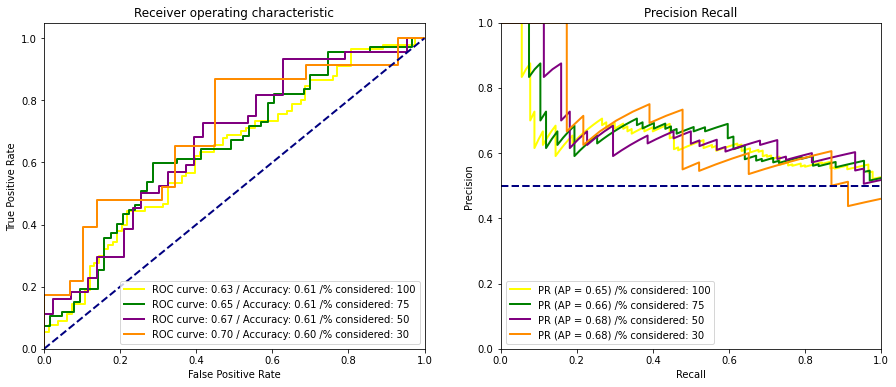

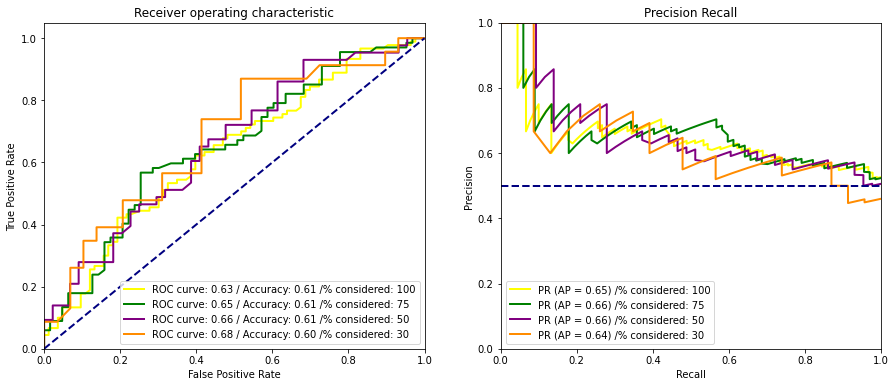

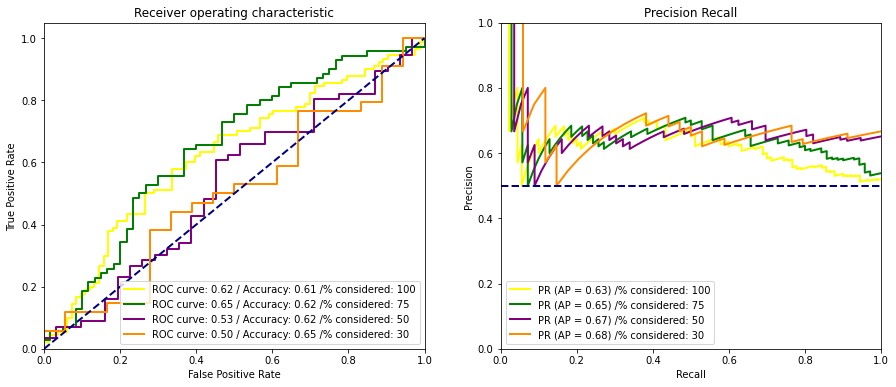

In [21]:
plot_a_report(*baseline)
plot_a_report(*odin)
plot_a_report(*conf_branch)

In [22]:
test_dataset = MultimodalMGMTPrivateDataset(os.path.join(path_test, "IRMs"), df, modalities=("FLAIR", "T1wCE"), fusion='intermediate', image_size=(180,180), depth=64)
dataloader_test = DataLoader(test_dataset, num_workers=40, shuffle=False, batch_size=1)

scores = []
predictions = []
true_labels = []
with torch.no_grad():
    for i, (volume, methylation_percentage) in enumerate(dataloader_test):
        volume = volume.to(device)
        outputs = model(volume)
        top_proba, preds = torch.max(outputs.softmax(1), 1)
        true_labels.extend(torch.where(methylation_percentage > 10., 1, 0).cpu().numpy())
        scores.extend(methyl_percentage_to_score(methylation_percentage).numpy())
        predictions.extend(torch.where(preds == 1, top_proba, 1 - top_proba)
                            .detach()
                            .cpu()
                            .numpy())

plot_a_report(scores, predictions, true_labels)
plt.savefig("../image_final/dicom_intermediate_tumor_centered_FLAIR-T1wCE.pdf")

[0.7190725, 0.71245337, 0.717792, 0.69674385, 0.6982684, 0.7093793, 0.7274937, 0.704754, 0.6918005, 0.72280055, 0.73812056, 0.70487434, 0.7234627, 0.6981689, 0.70879316, 0.7025684, 0.73047787, 0.7171603, 0.7281905, 0.74512374, 0.7336906, 0.70150435, 0.7257393, 0.69092274, 0.69027984, 0.7113414, 0.69279164, 0.7298954, 0.7070595, 0.7203439, 0.73544735, 0.7172249, 0.7298019, 0.7213992, 0.71061754, 0.715108, 0.7132818, 0.73958737, 0.73460984, 0.69869626, 0.70471126, 0.68614817, 0.7411269, 0.7040274, 0.725667, 0.7266772, 0.744182, 0.7018217, 0.7285949, 0.70366865, 0.72502816, 0.6919194, 0.71174437, 0.71647805, 0.70827717, 0.6861946, 0.7207168, 0.72793335, 0.7114228, 0.70374984, 0.71020067, 0.7128609, 0.71199507, 0.72651666, 0.71876264, 0.7230498, 0.72817093, 0.7122721, 0.69874346, 0.73152924, 0.7320016, 0.7263619, 0.69775426, 0.70911044, 0.7243546, 0.7252504, 0.70796514, 0.6900536, 0.73007405, 0.7171517, 0.7115962, 0.7213373, 0.73062813, 0.7108892, 0.6962053, 0.7068088, 0.7314102, 0.7031449

###### The end.